# Data Import and Preprocessing

In [1]:
# All imports, setup logging and get configuration file

from utils import get_configuration_file, setup_logging, impute_null_values
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns

setup_logging()
config = get_configuration_file()

/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1071885275.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Importing data

holiday_events = pd.read_csv(config["holiday_events_data_location"])
oil = pd.read_csv(config["oil_data_location"])
sample_submission = pd.read_csv(config["sample_submission_data_location"])
stores = pd.read_csv(config["stores_data_location"])
test = pd.read_csv(config["test_data_location"])
train = pd.read_csv(config["train_data_location"])
transactions = pd.read_csv(config["transactions_data_location"])

In [3]:
# Impute null values in oil prices table

oil.rename(columns={"dcoilwtico":"oil_price"},inplace = True)

for index in range(len(oil)):
    if np.isnan(oil.loc[index, "oil_price"]):
        above_oil_price_index = oil["oil_price"][:index].last_valid_index()
        below_oil_price_index = oil["oil_price"][index:].first_valid_index()
        if above_oil_price_index is not None and below_oil_price_index is not None:
            above_oil_price_value = oil.loc[above_oil_price_index, "oil_price"]
            below_oil_price_value = oil.loc[below_oil_price_index, "oil_price"]
            oil.loc[index, "oil_price"] = (above_oil_price_value+below_oil_price_value)/2
        if above_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[above_oil_price_index]
        if below_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[below_oil_price_index]
        
        

In [4]:
# Add holiday column in holiday_events file and rename columns

stores.rename(columns={"type":"store_type"}, inplace = True)
holiday_events.rename(columns={"type":"holiday_type"}, inplace = True)
holiday_events["holiday"] = np.where((holiday_events["holiday_type"].
                                      isin(["Holiday","Transfer","Event",
                                           "Bridge","Additional"]) &
                                     (holiday_events["transferred"]==False)),1,0)
holiday_events_national = holiday_events[holiday_events["locale"]=="National"]

In [5]:
# Merging data

# Merging with Oil data
training_dataset = train.merge(stores, on = "store_nbr", how = "inner")
training_dataset = training_dataset.merge(oil, on = "date", how = "left")

# Merging with holiday events
training_dataset_temp = training_dataset.merge(holiday_events[["date","locale_name",
                                                               "holiday"]], how = "left",
                                                                right_on = 
                                                                ["date","locale_name"], 
                                                                left_on = ["date","city"])
training_dataset_temp.rename(columns={"holiday":"local_holiday"},inplace=True)
training_dataset_temp.drop(columns="locale_name",inplace=True)

training_dataset_temp = training_dataset_temp.merge(holiday_events_national
                                                    [["date","holiday"]],how = "left", 
                                                    left_on = "date", right_on = "date")
training_dataset_temp.rename(columns={"holiday":"national_holiday"},inplace=True)

training_dataset_temp.fillna({"local_holiday":0,"national_holiday":0},inplace = True)

training_dataset = training_dataset_temp

# training_dataset

In [6]:
# Change data types

training_dataset["date"] = pd.to_datetime(training_dataset["date"])

In [7]:
# Impute Null values

training_dataset = impute_null_values(training_dataset, "oil_price")


KeyboardInterrupt: 

In [13]:
# Save the training dataset

# training_dataset.to_csv("training_dataset.csv",index=False)

In [15]:
training_dataset.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
oil_price           0
local_holiday       0
national_holiday    0
dtype: int64

In [99]:
training_dataset.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'local_holiday',
       'national_holiday'],
      dtype='object')

In [97]:
training_dataset.describe()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,local_holiday,national_holiday
count,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,2.074248e+06,3.008280e+06,3.008280e+06
mean,1.501579e+06,2.750037e+01,3.582643e+02,2.609735e+00,8.481395e+00,6.791413e+01,4.036858e-03,7.996928e-02
std,8.657256e+05,1.558533e+01,1.103486e+03,1.226302e+01,4.649769e+00,2.565828e+01,6.340791e-02,2.712457e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00,0.000000e+00
25%,7.520698e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.639500e+01,0.000000e+00,0.000000e+00
50%,1.502358e+06,2.800000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.335500e+01,0.000000e+00,0.000000e+00
75%,2.249081e+06,4.100000e+01,1.960000e+02,0.000000e+00,1.300000e+01,9.578500e+01,0.000000e+00,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,1.000000e+00,1.000000e+00


In [136]:
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008280 entries, 0 to 3008279
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       int64         
 6   city              object        
 7   state             object        
 8   store_type        object        
 9   cluster           int64         
 10  oil_price         float64       
 11  local_holiday     float64       
 12  national_holiday  float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(4)
memory usage: 298.4+ MB


# Data Visualization

/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)


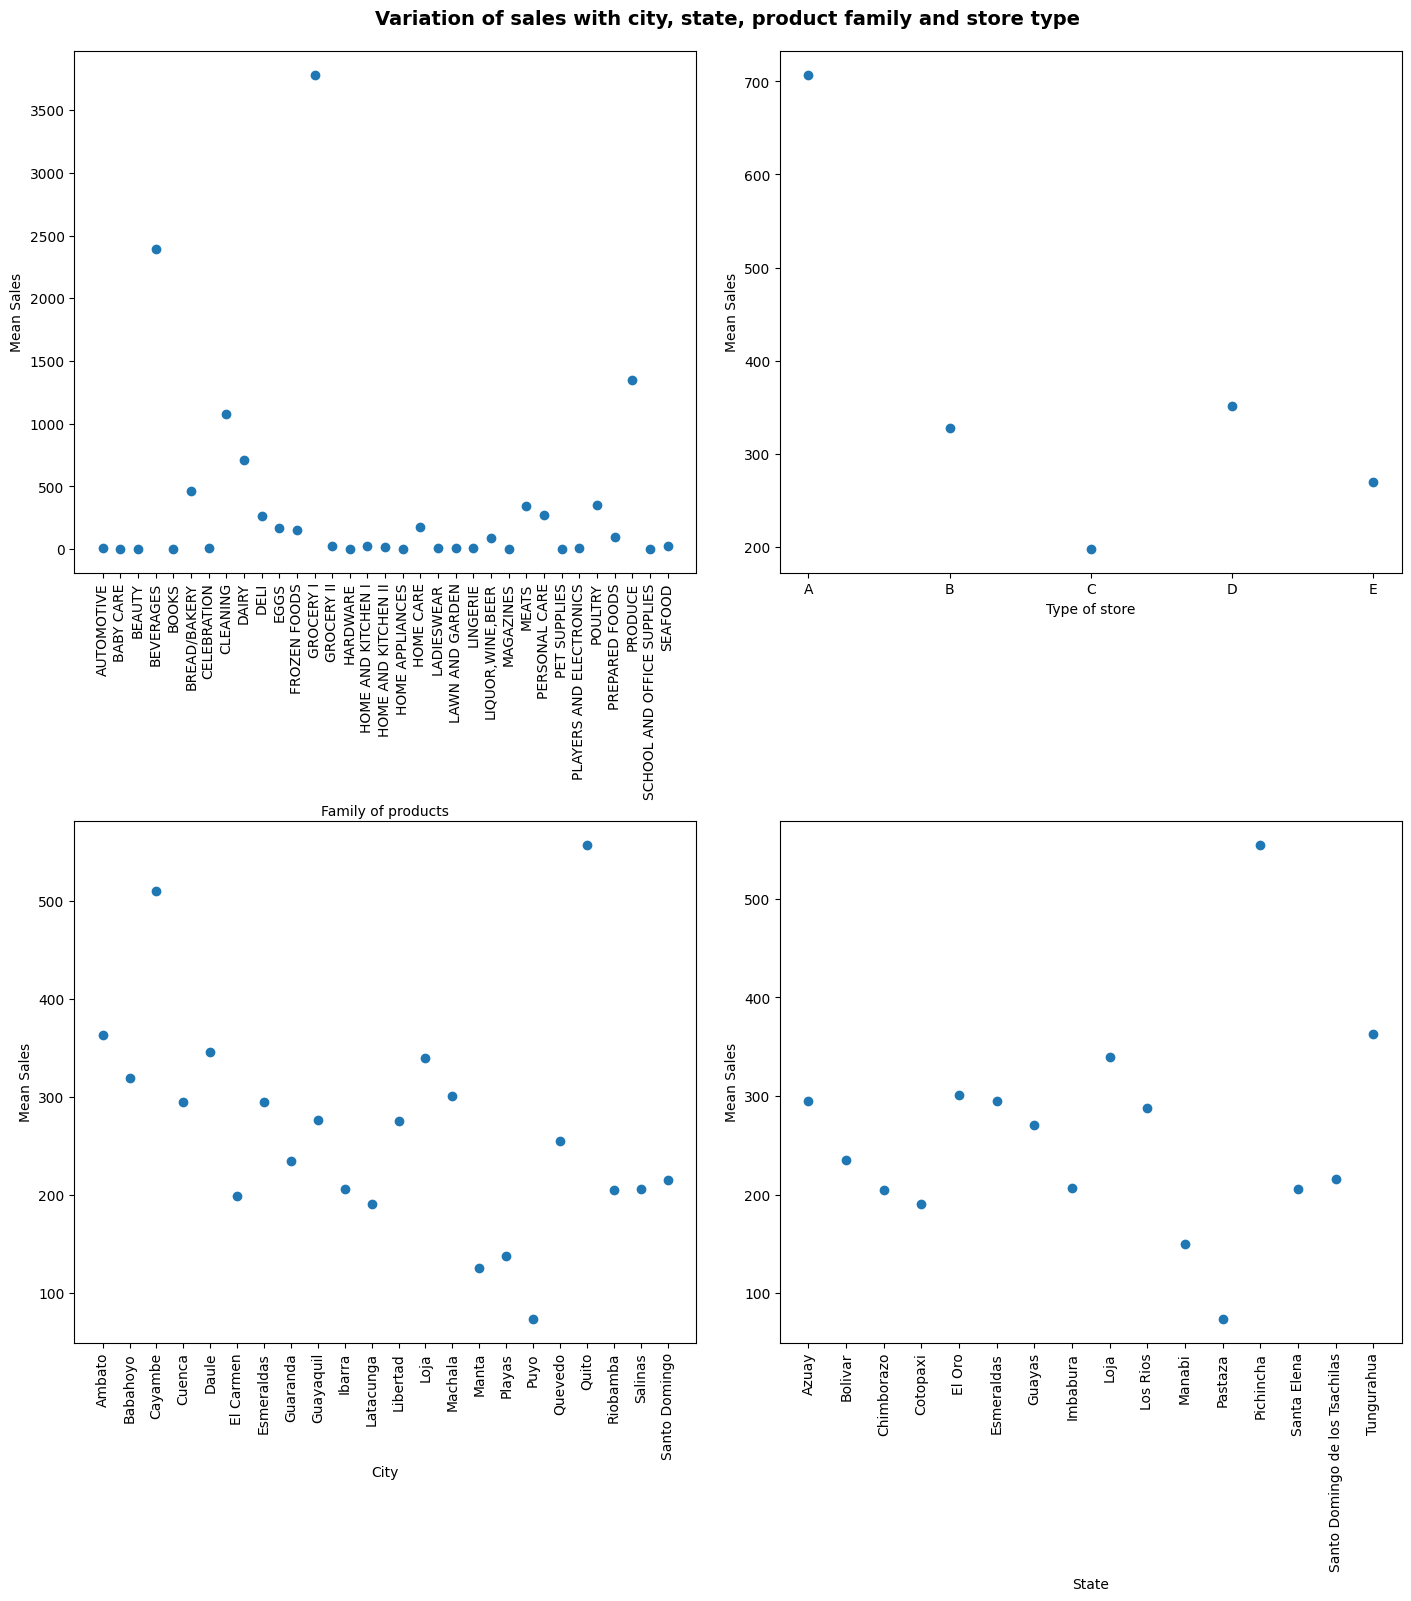

In [16]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
fig.suptitle("Variation of sales with city, state, product family and store type", size = 14, 
             weight = "bold")

fig.tight_layout(h_pad = 16, w_pad = 3)

groupby_column = "family"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
ax[0,0].set_xlabel("Family of products")
ax[0,0].set_ylabel("Mean Sales")

groupby_column = "store_type"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,1].set_xlabel("Type of store")
ax[0,1].set_ylabel("Mean Sales")

groupby_column = "city"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
ax[1,0].set_xlabel("City")
ax[1,0].set_ylabel("Mean Sales")

groupby_column = "state"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)
ax[1,1].set_xlabel("State")
ax[1,1].set_ylabel("Mean Sales")

plt.subplots_adjust(top=0.95)

# plt.savefig('Visualizations/Sales scatter plots .png')

In [76]:
groupby_column = ["store_nbr","family"]
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
grouped

,store_nbr,family,sales
0,1,AUTOMOTIVE,3.249408
1,1,BABY CARE,0.000000
2,1,BEAUTY,2.408768
3,1,BEVERAGES,1587.809834
4,1,BOOKS,0.125000
...,...,...,...
1777,54,POULTRY,52.835036
1778,54,PREPARED FOODS,61.226303
1779,54,PRODUCE,354.878766
1780,54,SCHOOL AND OFFICE SUPPLIES,0.626185


# Data Preparation for modelling

In [6]:
# Import data
training_dataset = pd.read_csv("training_dataset.csv")
training_dataset["date"] = pd.to_datetime(training_dataset["date"])
training_dataset = training_dataset.sort_values(by = "date")
print("Number of columns in dataset: ", len(training_dataset.columns))
training_dataset.columns

Number of columns in dataset:  13


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'oil_price', 'local_holiday',
       'national_holiday'],
      dtype='object')

In [8]:
# Divide data into X and y
X = training_dataset[config["training_columns"]]
y = training_dataset["sales"]
print("Number of columns in training dataset: ",len(X.columns))
X.columns

Number of columns in training dataset:  9


Index(['family', 'onpromotion', 'store_type', 'cluster', 'city', 'state',
       'oil_price', 'local_holiday', 'national_holiday'],
      dtype='object')

In [17]:
# One hot categorical columns

X = pd.get_dummies(X, columns = config["categorical_columns"], dtype = int)

X.drop(columns = config["encoded_columns_drop"], inplace = True)
len(X.columns)

92

In [18]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

93.56037084024904

In [19]:
# Drop columns based on sparsity in X
sparsity_column_threshold = config["sparsity_column_threshold"]

sparsity_column_wise = pd.DataFrame({"columnName":[],"sparsityPercent":[]})

for column in X.columns:
    non_zero_cells_count = np.count_nonzero(X[column])
    total_cells_count = X[column].size
    sparsity_column = (1-(non_zero_cells_count/total_cells_count))
    sparsity_column_wise = sparsity_column_wise._append({"columnName":column,"sparsityPercent":
                                                         sparsity_column}, ignore_index=True)

sparsity_column_wise.sort_values(by="sparsityPercent", ascending = False, inplace=True)
columns_to_drop = sparsity_column_wise[sparsity_column_wise["sparsityPercent"]>
                                       sparsity_column_threshold]["columnName"].tolist()

X_dropped_sparsity = X.drop(columns_to_drop, axis=1)
len(X_dropped_sparsity.columns)


26

In [20]:
# Calculate statistics on X
correlation_matrix = X_dropped_sparsity.corr()
X_dropped_sparsity_stats = X_dropped_sparsity.describe()

In [21]:
# Checking variance in each column

X_dropped_sparsity_stats.loc["std",:].sort_values(ascending=False)

oil_price                               25.695619
onpromotion                             12.263017
state_Pichincha                          0.477539
store_type_D                             0.471402
city_Quito                               0.471394
state_Guayas                             0.402803
store_type_A                             0.372675
city_Guayaquil                           0.355321
store_type_B                             0.355245
cluster_3                                0.335907
cluster_10                               0.314298
cluster_6                                0.314271
cluster_15                               0.289849
national_holiday                         0.271246
store_type_E                             0.261917
cluster_14                               0.261881
cluster_13                               0.261881
cluster_1                                0.229073
state_Manabi                             0.229052
state_Azuay                              0.229052


[]

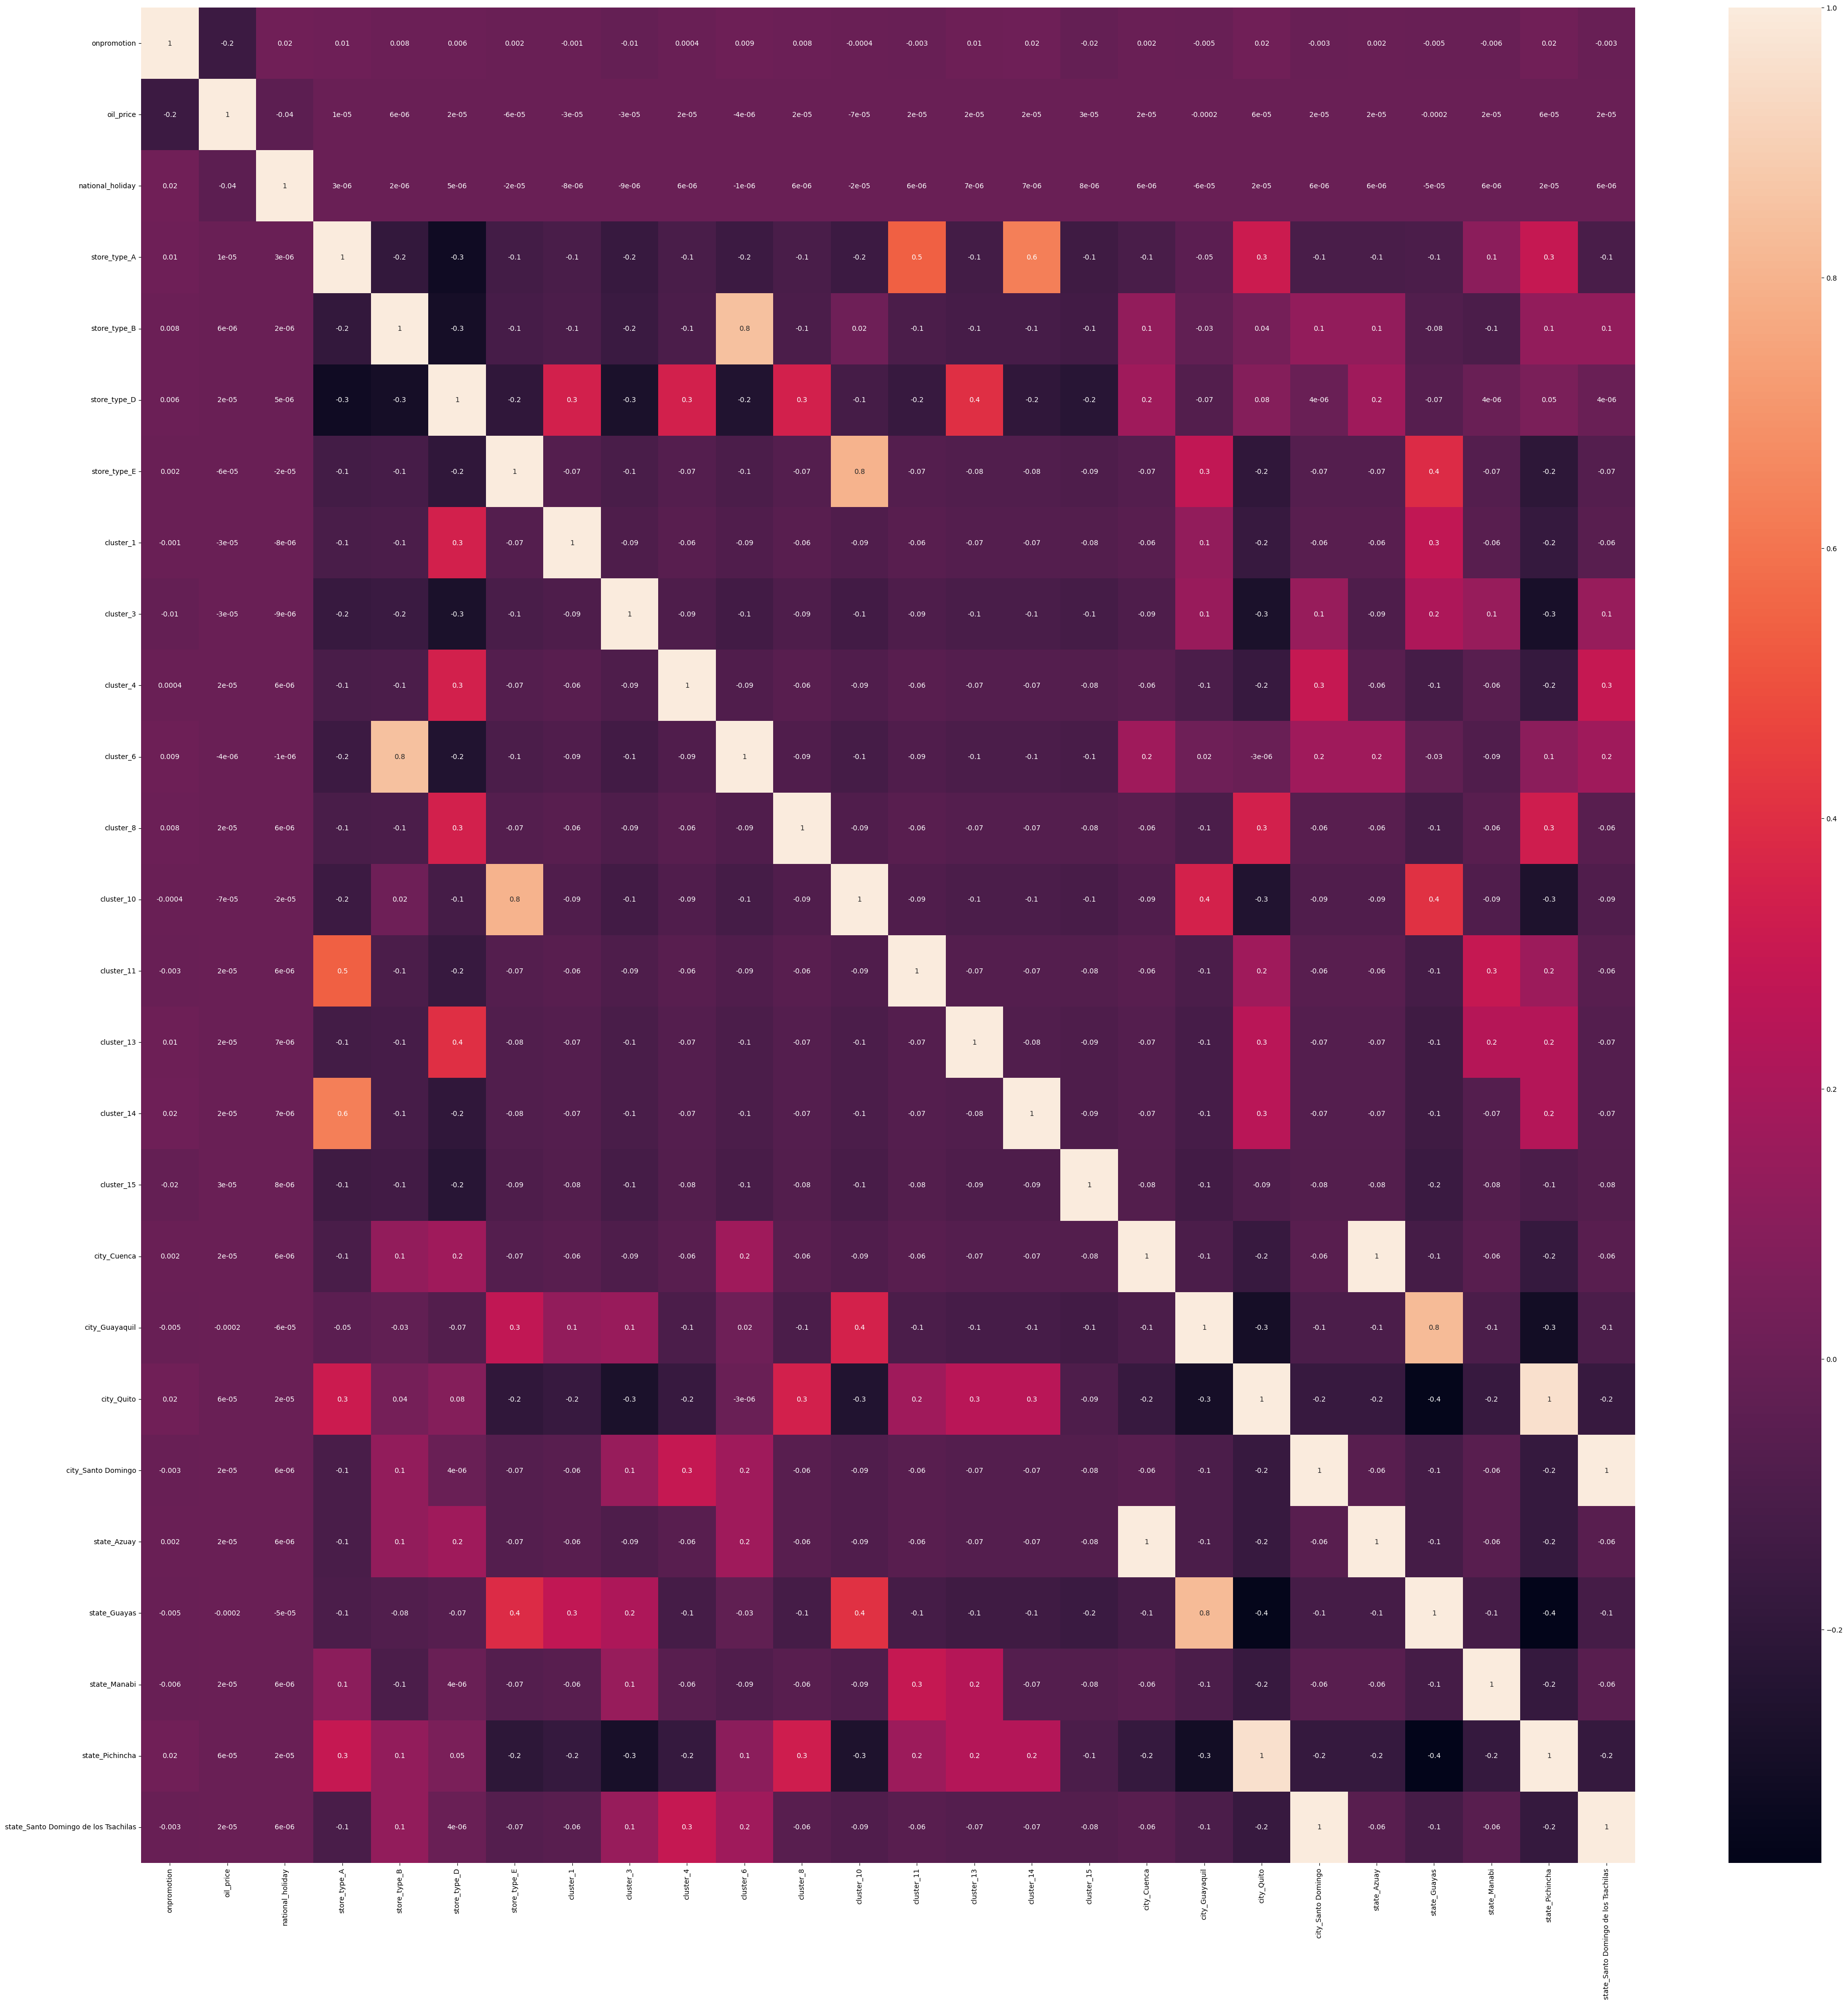

In [22]:
# Plot correlation heatmap
plt.figure(figsize=(48,48))
sns.heatmap(correlation_matrix, annot = True, fmt = '.1g')
plt.plot()

In [23]:
# Drop highly correlated features

correlation_matrix_absolute = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix_absolute.where(np.triu(np.ones(correlation_matrix_absolute.shape),
                                                   k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = config["correlation_threshold"]
columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("The columns to be dropped are: ", columns_to_drop)

# Drop features 
X_dropped_sparsity_correlation = X_dropped_sparsity.drop(columns_to_drop, axis=1)

print(len(X_dropped_sparsity_correlation.columns))

The columns to be dropped are:  ['state_Azuay', 'state_Pichincha', 'state_Santo Domingo de los Tsachilas']
23


In [24]:
correlations_with_target = pd.DataFrame({"columnName":[],"correlation":[]})
for column in X_dropped_sparsity_correlation.columns:
    correlation = {"columnName":column,"correlation":X_dropped_sparsity_correlation[column].corr(y)}
    correlations_with_target = correlations_with_target._append(correlation, ignore_index=True)

correlations_with_target.sort_values(by="correlation", ascending=False)

,columnName,correlation
0,onpromotion,0.427505
3,store_type_A,0.141296
19,city_Quito,0.127561
15,cluster_14,0.090008
11,cluster_8,0.063684
13,cluster_11,0.054076
2,national_holiday,0.017945
5,store_type_D,-0.004396
10,cluster_6,-0.004817
7,cluster_1,-0.006950


In [25]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X_dropped_sparsity_correlation.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

74.24148336099611

# Model training

In [26]:
X_dev, X_test, y_dev, y_test = train_test_split(X_dropped_sparsity_correlation, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25)

In [27]:
print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (1804968, 23)
X_val shape:  (601656, 23)
X_test shape:  (601656, 23)


## Linear Regression

In [28]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
model_linear.score(X_train, y_train)

0.21492351484312544

In [30]:
model_linear.score(X_val, y_val)

0.21529498141464565

## Random Forest

In [122]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
model_rf.score(X_train, y_train)

0.6514370233856224

In [123]:
model_rf.score(X_val, y_val)

0.4125585353232577

## Gradient Boosting

In [127]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
model_gb.score(X_train, y_train)

0.36097952075672746

In [128]:
model_gb.score(X_val, y_val)

0.3550774544918269